In [1]:
import numpy as np
import qutip as q
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Go']})
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.fontset'] = 'cm'
%matplotlib notebook

In [2]:
# Data from Table I in Phys. Rev. B 97, 094416 (2018)
# Euler angles (degrees) for 7F0 principal quadrupole axes, relative to lab frame
alpha_g = -29.9
beta_g = 53.4
gamma_g = 124.05

# Euler angles (degrees) for 5D0 principal quadrupole axes, relative to lab frame
alpha_e = 165.3
beta_e = 154.91
gamma_e = 107.81

# Euler angles (degrees) for dielectric axes, relative to lab frame
alpha_c = -140
beta_c = 172
gamma_c = -51

# following definitions in text
def rot_z(alpha):
    a = np.radians(alpha)
    c = np.cos(a)
    s = np.sin(a)
    return np.array([[c,s,0],[-s,c,0],[0,0,1]])

def rot_y(beta):
    b = np.radians(beta)
    c = np.cos(b)
    s = np.sin(b)
    return np.array([[c,0,-s],[0,1,0],[s,0,c]])

# rotation matrices
rot_g = np.matmul(rot_z(gamma_g),np.matmul(rot_y(beta_g), rot_z(alpha_g)))
rot_e = np.matmul(rot_z(gamma_e),np.matmul(rot_y(beta_e), rot_z(alpha_e)))
rot_c = np.matmul(rot_z(gamma_c),np.matmul(rot_y(beta_c), rot_z(alpha_c)))

In [3]:
# 7F0 quadrupole tensor components in principal axis frame (Eu-153)
# from Table III in Phys. Rev. B 97, 094416 (2018)
E_g = -7.19          # using eta = 3E/D = 0.674
D_g = -32.02         

# 5D0 quadrupole tensor components in principal axis frame (Eu-153)
E_e = 15.33          # using eta = 3E/D = 0.660
D_e = 69.67

# quadrupole tensors in lab frame
Q_g = np.matmul(rot_g, np.matmul(np.array([[-E_g, 0, 0],[0, E_g, 0],[0, 0, D_g]]), np.transpose(rot_g)))
Q_e = np.matmul(rot_e, np.matmul(np.array([[-E_e, 0, 0],[0, E_e, 0],[0, 0, D_e]]), np.transpose(rot_e)))

# quadrupole tensors in dielectric frame
Q_gd = np.matmul(rot_c, np.matmul(Q_g, np.transpose(rot_c)))
Q_ed = np.matmul(rot_c, np.matmul(Q_e, np.transpose(rot_c)))

In [4]:
I=5/2

# x = D1 dielectric axis
# y = D2 dielectric axis
# z = b dielectric axis

Iz = q.jmat(I,'z')
Ix = q.jmat(I,'x')
Iy = q.jmat(I,'y')

In [5]:
### The principal axes for the M tensor are taken from the numbers for 151-Eu 
### assumption is that the M tensor axes are set by the crystal field

# Euler angles (degrees) for principal axes of 7F0 magnetic tensor, relative to lab frame
# from Table I in Phys. Rev. B 97, 094416 (2018)

mu_N = 7.622593285 # MHz/T
mu_ratio = 1.5324/3.4717 # = mu_153/mu_151, from https://www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html
quadrupole_moment_ratio = 2.412/0.903 


#---------------  7F0 state  ------------------------
alpha_mg = 105.25
beta_mg = 163.74
gamma_mg = 124.56

# M tensor components for 7F0 in principal frame, numbers for 151-Eu
g_1g = 4.30 # MHz/T
g_2g = 5.559
g_3g = -10.891

rot_mg = np.matmul(rot_z(gamma_mg),np.matmul(rot_y(beta_mg), rot_z(alpha_mg))) 

# Gyromagnetic tensor in PRB paper's measurement frame
M_g = np.matmul(rot_mg, np.matmul(np.array([[g_1g, 0, 0],[0, g_2g, 0],[0, 0, g_3g]]), np.transpose(rot_mg)))

# Gyromagnetic tensor in dielectric frame
M_gd = np.matmul(rot_c, np.matmul(M_g, np.transpose(rot_c)))

def H_mag_g(Bx,By,Bz):
    # B fields in units of T
    IMB = Ix*(M_gd[0][0]*Bx + M_gd[0][1]*By + M_gd[0][2]*Bz) + \
          Iy*(M_gd[1][0]*Bx + M_gd[1][1]*By + M_gd[1][2]*Bz) + \
          Iz*(M_gd[2][0]*Bx + M_gd[2][1]*By + M_gd[2][2]*Bz)

    # assuming that the M tensor is just scaled by the ratio of nuclear magnetic moments
    # magnetic moment along D1 axis, in units of mu_N for 153-Eu
    return IMB * mu_ratio    # MHz

# magnetic moment operator along D1 axis in 7F0
mu_xg = -(M_gd[0][0]*Ix + M_gd[0][1]*Iy + M_gd[0][2]*Iz)  * (mu_ratio / mu_N)
         

#------------------  5D0 state  ---------------------------
alpha_me = 70.53
beta_me = 163.74
gamma_me = 124.56

# 1st order Zeeman shift components for 5F0 in principal frame, numbers for 151-Eu
g_1e = 9.11 # MHz/T
g_2e = 9.158
g_3e = 9.069

rot_me = np.matmul(rot_z(gamma_me),np.matmul(rot_y(beta_me), rot_z(alpha_me))) 

# Gyromagnetic tensor in PRB paper's measurement frame
M_e = np.matmul(rot_me, np.matmul(np.array([[g_1e, 0, 0],[0, g_2e, 0],[0, 0, g_3e]]), np.transpose(rot_me)))

# Gyromagnetic tensor in dielectric frame
M_ed = np.matmul(rot_c, np.matmul(M_e, np.transpose(rot_c)))

def H_mag_e(Bx,By,Bz):
    # B fields in units of T
    IMB = Ix*(M_ed[0][0]*Bx + M_ed[0][1]*By + M_ed[0][2]*Bz) + \
          Iy*(M_ed[1][0]*Bx + M_ed[1][1]*By + M_ed[1][2]*Bz) + \
          Iz*(M_ed[2][0]*Bx + M_ed[2][1]*By + M_ed[2][2]*Bz)
    return IMB * mu_ratio   # MHz

Here we have assumed that the M tensor for 153-Eu can be obtained by scaling it from the tensor for 151-Eu. This is only a good assumption if the magnetic moment is entirely due to the nucleus. But in Eu:YSO, there is off-diagonal hyperfine coupling, which admixes some $|^7F_1\rangle$ into the $|^7F_0\rangle$ state. This admixing of $|^7F_1\rangle$ leads to a contribution to the total magnetic moment, in addition to that from the nuclear magnetic moment. 

To check if this is a good assumption, we can use the known values of the Q tensor to test if the ${}^7F_1-{}^7F_0$ admixing is significant.

#### Checking if quadrupole moment ratio matches Q tensor ratio

In [6]:
print(quadrupole_moment_ratio)  # bare nuclear quadrupole moment ratio, from https://www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html
print(32.02/12.38)    # ratio of "D" parameter in Q tensor for 153-Eu and 151-Eu in 7F0 state, from Table III in Phys. Rev. B 97, 094416 (2018)
print(69.67/27.26)    # ratio of "D" parameter in Q tensor for 153-Eu and 151-Eu in 5D0 state, from same 

2.67109634551495
2.5864297253634896
2.5557593543653705


Based on the fairly close similarity between the nuclear quadrupole moment ratio and the Q tensor ratio for 153-Eu:151-Eu, we can conclude that the Q tensor is mainly determined by the nuclear quadrupole moment interacting with the electric field gradient in the crystal. The effect of the off-diagonal hyperfine interaction, which leads to pseudo-quadrupole (ie, 2nd order hfs) contributions to the Q tensor, is fairly negligible here. (Note that the above quadrupole moment ratio is for the _bare_ nuclei -- we have not accounted for nuclear diamagnetic shielding corrections to the nuclear moments inside the atoms, which could be responsible for the small discrepancies in the numbers above.)

So it is reasonable to expect that the M tensor will not have significant contributions from electronic moments due to the 7F0-7F1 admixing, and therefore the M tensor ratio for 153:151 should be in approximately the same ratio as the bare nuclear magnetic moments. 

We should estimate the mixing amplitude and the magnetic moment correction in a separate way as well.

### Eigenvalues and eigenvectors of the hyperfine Hamiltonian 

In [7]:
# ---------- ground state hyperfine Hamiltonian ----------
H_qg = Ix*(Q_gd[0][0]*Ix + Q_gd[0][1]*Iy + Q_gd[0][2]*Iz) + \
       Iy*(Q_gd[1][0]*Ix + Q_gd[1][1]*Iy + Q_gd[1][2]*Iz) + \
       Iz*(Q_gd[2][0]*Ix + Q_gd[2][1]*Iy + Q_gd[2][2]*Iz)   
        
H_g = H_qg + H_mag_g(2e-2,0,0)     # 200 G B-field along x-axis

E_g, eigenvecs_g = H_g.eigenstates()
Ix_ev_g = np.array([(k.dag()*Ix*k).tr() for k in eigenvecs_g])
Iy_ev_g = np.array([(k.dag()*Iy*k).tr() for k in eigenvecs_g])
Iz_ev_g = np.array([(k.dag()*Iz*k).tr() for k in eigenvecs_g])
I_ev_g = np.transpose(np.array([Ix_ev_g, Iy_ev_g, Iz_ev_g]))

mu_xg_ev = np.array([(k.dag()*mu_xg*k).tr() for k in eigenvecs_g])

# ---------- excited state hyperfine Hamiltonian  ------------
H_qe = Ix*(Q_ed[0][0]*Ix + Q_ed[0][1]*Iy + Q_ed[0][2]*Iz) + \
       Iy*(Q_ed[1][0]*Ix + Q_ed[1][1]*Iy + Q_ed[1][2]*Iz) + \
       Iz*(Q_ed[2][0]*Ix + Q_ed[2][1]*Iy + Q_ed[2][2]*Iz)

H_e = H_qe + H_mag_e(2e-2,0,0)

E_e, eigenvecs_e = H_e.eigenstates()
Ix_ev_e = np.array([(k.dag()*Ix*k).tr() for k in eigenvecs_e])
Iy_ev_e = np.array([(k.dag()*Iy*k).tr() for k in eigenvecs_e])
Iz_ev_e = np.array([(k.dag()*Iz*k).tr() for k in eigenvecs_e])
I_ev_e = np.transpose(np.array([Ix_ev_e, Iy_ev_e, Iz_ev_e]))

## Nuclear Schiff moment sensitivities & magnetic moments in ${}^7F_0$

<IPython.core.display.Javascript object>


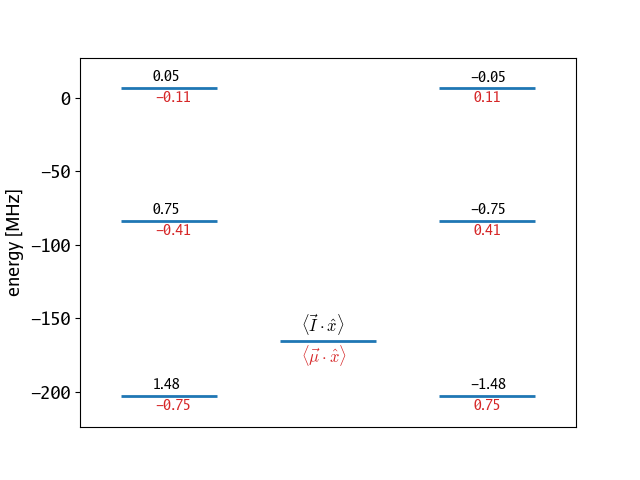

In [69]:
fig,ax = plt.subplots()

# ax.set_xlabel(r"$\langle I_z \rangle$")
ax.get_xaxis().set_visible(False)
ax.set_ylabel("energy [MHz]")

ax.errorbar(np.sign(Iz_ev_g),E_g,xerr=0.3,capsize=0,elinewidth=2,fmt='.',markersize=0)
for i in range(len(eigenvecs_g)):
    nsm_text = f"{round(Ix_ev_g[i],2)}"    # label is <I.x>, proportional to NSM sensitivity
    ax.annotate(nsm_text,
                xy=(np.sign(Iz_ev_g[i]),E_g[i]),xycoords='data',
                xytext=(-12,5), textcoords='offset points',
                color='k',size=10)

    mag_moment_text = f"{round(mu_xg_ev[i],2)}"   # label is <mu_x>
    ax.annotate(mag_moment_text,
                xy=(np.sign(Iz_ev_g[i]),E_g[i]),xycoords='data',
                xytext=(-10,-10), textcoords='offset points',
                color='C3',size=10)
    
ax.annotate(r"$\langle \vec{I} \cdot \hat{x} \rangle$",
            xy=(-0.08,-150),xycoords='data',
            xytext=(-10,-10), textcoords='offset points',
            color='k',size=12)
ax.errorbar(0,-165,xerr=0.3,capsize=0,elinewidth=2,fmt='.',markersize=0,color='C0')
ax.annotate(r"$\langle \vec{\mu} \cdot \hat{x} \rangle$",
            xy=(-0.08,-170),xycoords='data',
            xytext=(-10,-10), textcoords='offset points',
            color='C3',size=12)


ax.margins(0.1,0.1)
plt.show()

The position of the rf resonance lines for the $\{a,b\}$ manifold is as follows: 

In [70]:
a,abar,b,bbar = E_g[:4]
resonances = np.array([b-abar,bbar-abar,b-a,bbar-a])
print(resonances - np.average(resonances))
mu_a,mu_b = mu_xg_ev[0],mu_xg_ev[2]

# print(mu_a,mu_b)
# relating these with our data from 2023-11-10

# B-field consistency check
print((85.9--40.9)*1e-3/(2*(mu_a-mu_b) * mu_N)) # T, from comparing bbar-abar and b-a resonances
print((259--202.1)*1e-3/(2*(mu_a+mu_b) * mu_N)) # T, from compariing b-abar and bbar-a resonances
print((87.4--41)*1e-3/(2*(mu_a-mu_b) * mu_N)) # T, from comparing bbar-abar and b-a resonances
print((263--199)*1e-3/(2*(mu_a+mu_b) * mu_N)) # T, from compariing b-abar and bbar-a resonances

[-0.17693698 -0.05062455  0.05062455  0.17693698]
0.02505350329231391
0.026051042600163516
0.02536963582597087
0.026101890438680424


### Calculating overlap between 7F0 and 5D0 eigenstates for optical transition

In [71]:
state_labels_g = ["a", "a'", "b", "b'", "c", "c'"]
state_labels_e = ["C", "C'", "B", "B'", "A", "A'"]
# state_labels_g = [r'\ket{\bar{a}}', r'\ket{a}', r'\ket{\bar{b}}', r'\ket{b}', r'\ket{\bar{c}}', r'\ket{c}']
# state_labels_e = [r'\ket{\bar{c}}_e', r'\ket{c}_e', r'\ket{\bar{b}}_e', r'\ket{b}_e', r'\ket{\bar{a}}_e', r'\ket{a}_e']

In [72]:
# Hyperfine mixing is weak, so the relative transition probability between nuclear sublevels of the ground and excited states is determined by the overlap of the nuclear states
rel_transition_prob = np.zeros((len(eigenvecs_g), len(eigenvecs_e)))

for i in range(len(eigenvecs_g)):
    for j in range(len(eigenvecs_e)):
        rel_transition_prob[i][j] = np.abs(eigenvecs_g[i].overlap(eigenvecs_e[j]) * eigenvecs_e[j].overlap(eigenvecs_g[i]))

In [73]:
def eigenvecs_polar_form(eigenvecs):
    polar_form = []
    for i in range(len(eigenvecs)):
        polar_form += [[]]
        for j in range(len(eigenvecs)):
            amplitude = eigenvecs[i][j][0][0]
            polar_form[i] += [(np.absolute(amplitude),np.angle(amplitude,True))]
            
    return polar_form
    
def print_complex_tuple(z):
    angle = np.round(z[1],1)
    mag = np.round(z[0],3)
    return f"({mag}<{angle} deg)"

def print_states(eigenvecs,E,m_I,state_labels,other_eigenvecs,other_state_labels):
    polar_form = eigenvecs_polar_form(eigenvecs)
    for i in range(len(eigenvecs)):
        print("|"+state_labels[i]+"> = "+print_complex_tuple(polar_form[i][0])+"|+5/2> + " +print_complex_tuple(polar_form[i][1])+"|+3/2> + " +print_complex_tuple(polar_form[i][2])+"|+1/2> + " +print_complex_tuple(polar_form[i][3])+"|-1/2> + " +print_complex_tuple(polar_form[i][4])+"|-3/2> + "+print_complex_tuple(polar_form[i][5])+"|-5/2> ")
        print(f"\tE = {E[i]:.4}, m_I = {m_I[i]:.3}")
        print()
        for j in range(len(other_eigenvecs)):
            print("\t|<"+other_state_labels[j]+"|"+state_labels[i]+">|^2 = "+f"{rel_transition_prob[i][j]:.3}")
        print()

In [74]:
print("7F0 nuclear sublevels and overlaps with 5D0 nuclear sublevels:\n")
print_states(eigenvecs_g, E_g,Ix_ev_g,state_labels_g,eigenvecs_e,state_labels_e)

df = pd.DataFrame(np.transpose(np.round(rel_transition_prob,3)), columns=state_labels_g)
df.index = state_labels_e

df.to_latex()

7F0 nuclear sublevels and overlaps with 5D0 nuclear sublevels:

|a> = (0.633<0.0 deg)|+5/2> + (0.667<-154.5 deg)|+3/2> + (0.366<61.1 deg)|+1/2> + (0.139<-53.0 deg)|-1/2> + (0.038<-171.9 deg)|-3/2> + (0.013<144.3 deg)|-5/2> 
	E = -203.0, m_I = -1.48

	|<C|a>|^2 = 0.856
	|<C'|a>|^2 = 0.0136
	|<B|a>|^2 = 0.0316
	|<B'|a>|^2 = 0.067
	|<A|a>|^2 = 0.00095
	|<A'|a>|^2 = 0.0306

|a'> = (0.013<180.0 deg)|+5/2> + (0.038<-43.7 deg)|+3/2> + (0.139<17.3 deg)|+1/2> + (0.367<83.3 deg)|-1/2> + (0.667<118.9 deg)|-3/2> + (0.633<144.5 deg)|-5/2> 
	E = -202.8, m_I = 1.48

	|<C|a'>|^2 = 0.0135
	|<C'|a'>|^2 = 0.856
	|<B|a'>|^2 = 0.0671
	|<B'|a'>|^2 = 0.0314
	|<A|a'>|^2 = 0.0306
	|<A'|a'>|^2 = 0.000952

|b> = (0.542<0.0 deg)|+5/2> + (0.168<89.8 deg)|+3/2> + (0.748<-134.4 deg)|+1/2> + (0.266<84.1 deg)|-1/2> + (0.115<-0.7 deg)|-3/2> + (0.187<-147.2 deg)|-5/2> 
	E = -83.73, m_I = -0.753

	|<C|b>|^2 = 0.111
	|<C'|b>|^2 = 0.00395
	|<B|b>|^2 = 0.397
	|<B'|b>|^2 = 0.319
	|<A|b>|^2 = 0.0402
	|<A'|b>|^2 = 0.129

|b'> 

"\\begin{tabular}{lrrrrrr}\n\\toprule\n & a & a' & b & b' & c & c' \\\\\n\\midrule\nC & 0.856000 & 0.014000 & 0.111000 & 0.004000 & 0.005000 & 0.011000 \\\\\nC' & 0.014000 & 0.856000 & 0.004000 & 0.110000 & 0.011000 & 0.005000 \\\\\nB & 0.032000 & 0.067000 & 0.397000 & 0.319000 & 0.150000 & 0.035000 \\\\\nB' & 0.067000 & 0.031000 & 0.319000 & 0.397000 & 0.036000 & 0.150000 \\\\\nA & 0.001000 & 0.031000 & 0.040000 & 0.129000 & 0.322000 & 0.478000 \\\\\nA' & 0.031000 & 0.001000 & 0.129000 & 0.040000 & 0.477000 & 0.321000 \\\\\n\\bottomrule\n\\end{tabular}\n"